## Create LSTM models to forecast depth to ground water

## How does LSTM work?

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.random import set_seed

2025-02-14 17:01:47.998591: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-14 17:01:47.999508: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-14 17:01:48.001809: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-14 17:01:48.008285: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-14 17:01:48.018318: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

## Load preprocessed data

In [2]:
df = pd.read_csv("../Processed_data/processed_data.csv", index_col="Unnamed: 0")
df.head()

,Date,Rainfall,Depth_to_groundwater,Temperature,Drainage_Volume,Hydrometry,Depth_to_groundwater_diff_1,Depth_to_groundwater_diff_2,Month,Day,...,Hydrometry_res,Depth_to_groundwater_trend,Depth_to_groundwater_seasonal,Depth_to_groundwater_res,Depth_to_groundwater_diff_1_trend,Depth_to_groundwater_diff_1_seasonal,Depth_to_groundwater_diff_1_res,Depth_to_groundwater_diff_2_trend,Depth_to_groundwater_diff_2_seasonal,Depth_to_groundwater_diff_2_res
0,2009-01-01,0.0,-31.14,5.2,-24530.688,2.4,0.00,0.00,1,1,...,0.053435,-29.587662,-0.673243,-0.879095,0.000478,-0.003122,0.002644,-0.000085,0.020845,-0.020760
1,2009-01-02,0.0,-31.11,2.3,-28785.888,2.5,0.03,0.03,1,2,...,0.169867,-29.582438,-0.660836,-0.866727,0.000492,0.012756,0.016752,-0.000085,0.015900,0.014185
2,2009-01-03,0.0,-31.07,4.4,-25766.208,2.4,0.04,0.01,1,3,...,0.105889,-29.577213,-0.619997,-0.872789,0.000506,0.024219,0.015275,-0.000085,0.011693,-0.001608
3,2009-01-04,0.0,-31.05,0.8,-27919.296,2.4,0.02,-0.02,1,4,...,0.088990,-29.571989,-0.591599,-0.886412,0.000520,0.028416,-0.008936,-0.000084,0.004222,-0.024138
4,2009-01-05,0.0,-31.01,-1.9,-29854.656,2.3,0.04,0.02,1,5,...,-0.027932,-29.566765,-0.573141,-0.870094,0.000534,0.018473,0.020994,-0.000084,-0.009919,0.030004


## Parameters for the model

In [3]:
## set seed for reproducability
set_seed(5678)

### how many steps for future forecast
len_forecast = 10
look_back = 50

## num folds
k = 10

### num nodes per layer
LSTM_layer1 = 64
LSTM_layer2 = 32
LSTM_layer3 = 32
Dense_layer1 = 32


## Create training and testing set

In [4]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits = k)

## Process time series as input for LSTM
For LSTM, similar to any other supervised learning model we need labeled input data.
In this case, one training example is a subset of the time series, with the label being the following value.
For example, if we set the input length of our model to be 50 values, then an X_train would be the first 50 points of the time series, with y_train being the 51st value of the time series

In [5]:
def split_time_series(sequence, num_steps):
    
    X = np.zeros(shape = (len(sequence) - num_steps - 1, num_steps))
    y = np.zeros(shape = len(sequence) - num_steps - 1)
    for i in range(len(sequence) - num_steps - 1):
        X[i] = sequence[i:i+50]
        y[i] = sequence[i+51]
        
    return X, y

## Create training set
Create training set to train the model
Create holdout set to compare performance with ARIMA model

In [6]:
start_index = -len_forecast

X = None
y = None

for fold, (train_index, holdout_index) in enumerate(tscv.split(df.Depth_to_groundwater)):
    train_sequence = train_index[start_index + len_forecast:]
    start_index = train_index[-1]
    
    split_sequence, holdout = df.Depth_to_groundwater[train_index], df.Depth_to_groundwater[holdout_index]
    holdout = holdout[:len_forecast]
    
    seqX, label = split_time_series(split_sequence, look_back)
    

    try:
        X = np.concat([X,seqX])
        y = np.concat([y,label])
        
    except:
        X = seqX
        y = label


## Split samples into training and testing
- Xtrain & Xtest should have shape (num samples, num features, look_back)

- In our case we have 1 feature and look_back has been set to 50

In [7]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.1, random_state=1234)

### Reshape for LSTM
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], 1, Xtrain.shape[1]))
Xtest = np.reshape(Xtest, (Xtest.shape[0], 1, Xtest.shape[1]))


## Add callback  to stop early

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop_callback = EarlyStopping(
    monitor = 'val_loss',
    patience = 50,
    restore_best_weights=True)


## Fit the model 

In [9]:
Xtrain.shape, ytrain.shape

((3390, 1, 50), (3390,))

In [10]:
Xtest.shape, ytest.shape

((377, 1, 50), (377,))

## Create the model

In [44]:
model = Sequential()

model.add(LSTM(LSTM_layer1, activation='relu', return_sequences=True, input_shape=(1, look_back)))
model.add(LSTM(LSTM_layer2, activation='relu', return_sequences=True))
model.add(LSTM(LSTM_layer3, activation='relu'))

model.add(Dense(Dense_layer1, activation = 'relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [45]:
history = model.fit(Xtrain, ytrain,
                  validation_data=(Xtest, ytest),
                  epochs=500, 
                  callbacks=early_stop_callback,
                  verbose=2)

Epoch 1/500
106/106 - 3s - 28ms/step - loss: 294.7461 - val_loss: 0.3858
Epoch 2/500
106/106 - 0s - 1ms/step - loss: 0.3653 - val_loss: 0.3617
Epoch 3/500
106/106 - 0s - 1ms/step - loss: 0.3528 - val_loss: 0.3539
Epoch 4/500
106/106 - 0s - 1ms/step - loss: 0.3479 - val_loss: 0.3479
Epoch 5/500
106/106 - 0s - 1ms/step - loss: 0.3257 - val_loss: 0.3037
Epoch 6/500
106/106 - 0s - 1ms/step - loss: 0.3088 - val_loss: 0.2684
Epoch 7/500
106/106 - 0s - 1ms/step - loss: 0.2325 - val_loss: 0.1497
Epoch 8/500
106/106 - 0s - 1ms/step - loss: 0.3004 - val_loss: 0.1828
Epoch 9/500
106/106 - 0s - 1ms/step - loss: 0.1423 - val_loss: 0.1000
Epoch 10/500
106/106 - 0s - 1ms/step - loss: 0.0852 - val_loss: 0.0651
Epoch 11/500
106/106 - 0s - 1ms/step - loss: 0.0611 - val_loss: 0.0584
Epoch 12/500
106/106 - 0s - 1ms/step - loss: 0.0543 - val_loss: 0.0370
Epoch 13/500
106/106 - 0s - 1ms/step - loss: 0.0465 - val_loss: 0.0353
Epoch 14/500
106/106 - 0s - 1ms/step - loss: 0.0441 - val_loss: 0.0361
Epoch 15/500

## Plot validation loss functions

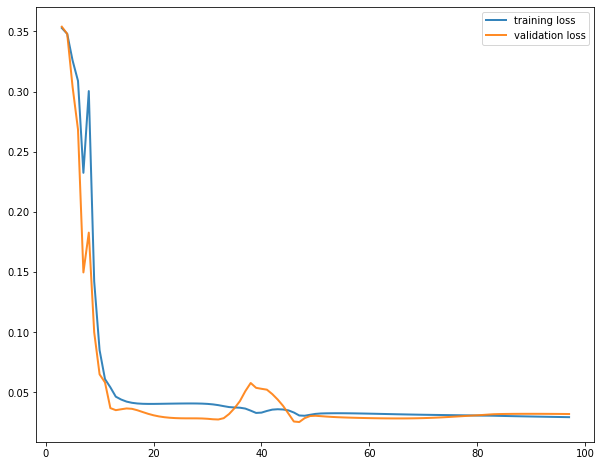

In [46]:
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = np.arange(1, len(train_loss) + 1)

skipstep = 2

plt.figure(figsize=(10,8))
plt.plot(epochs[skipstep:], train_loss[skipstep:], label = "training loss", linewidth = 2, alpha = 0.9)
plt.plot(epochs[skipstep:], val_loss[skipstep:], label = "validation loss", linewidth = 2, alpha = 0.9)

plt.legend()

## Forecast on test set

In [14]:
def forecast_LSTM(model, last_sequence, look_back, len_forecast):
    
    predictions = []
    LSTM_input = last_sequence.copy()
    
    #print(LSTM_input)
    LSTM_input = np.reshape(LSTM_input, (1, 1, look_back))
    
    #print(LSTM_input)
    for i in range(len_forecast):
        pred_val = model.predict(LSTM_input)
        predictions.append(pred_val[0])
                
        ##update the LSTM input sequence
        ##using roll, every value is shifted back by one, and the first value becomes the last value
        ## replace the last value with the predicted value
        LSTM_input = np.roll(LSTM_input, shift=-1)
        LSTM_input[0, 0,-1] = pred_val[0,0]
        
    return predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━

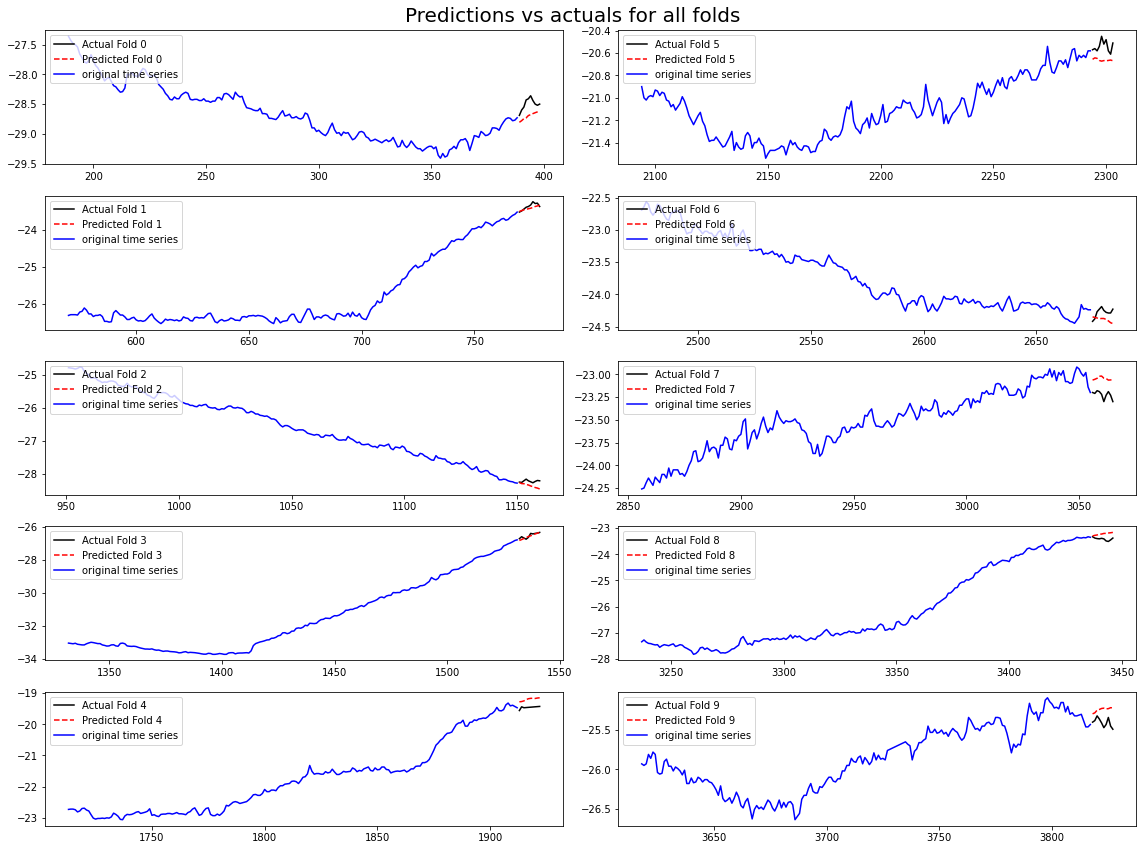

In [15]:
#fig, ax = plt.subplots(5,2, figsize = (16,12))
MSE_scores = []
MAE_scores = []

fig, ax = plt.subplots(5,2, figsize = (16,12))

for fold, (train_index, holdout_index) in enumerate(tscv.split(df.Depth_to_groundwater_diff_2)):
    
    ax2 = int(fold/5)
    ax1 = int(fold%5)
#     print(ax1, ax2)
    
    #### create holdout sets using split_time_series 
    train, holdout = df.Depth_to_groundwater[train_index], df.Depth_to_groundwater[holdout_index]
    holdout = holdout[:len_forecast]
    
        
    #### generate models predictions
    last_sequence = train[-look_back:]
    predictions = forecast_LSTM(model, last_sequence, look_back, len_forecast)


    ### get mse and mae
    mse = mean_squared_error(holdout, predictions)
    mae = mean_absolute_error(holdout, predictions)

    MSE_scores.append(mse)
    MAE_scores.append(mae)
    
    
    #### plot test and predicted
    ax[ax1, ax2].plot(holdout_index[:len_forecast], df.Depth_to_groundwater[holdout_index[:len_forecast]], color="black", label=f"Actual Fold {fold}")  # Test actuals
    ax[ax1, ax2].plot(holdout_index[:len_forecast], predictions, color="red", linestyle="dashed", label=f"Predicted Fold {fold}")  # Predictions

    # Confidence interval shading
    #ax[ax1, ax2].fill_between(test_index[:10], upper_conf_trans, lower_conf_trans, color='red', alpha=0.2)
    ax[ax1, ax2].plot(train_index[-200:], df.Depth_to_groundwater[train_index[-200:]], color='blue', label ="original time series", zorder = 1)
    ax[ax1, ax2].legend(loc="upper left")
    
fig.suptitle("Predictions vs actuals for all folds", fontsize=20)
plt.tight_layout()

## Parameter tuning
- using grid search find optimal hyper parameter
- This will be evaluated on the test set, not the holdout set

- We will tune LSTM_layer1, LSTM_layer2, LSTM_layer3, and look_back

In [23]:
def create_model(LSTM_layer1, LSTM_layer2, LSTM_layer3, Look_back):
    model = Sequential()
    
    ## LSTM layers
    model.add(LSTM(LSTM_layer1, activation='relu', return_sequences=True, input_shape=(1, look_back)))
    model.add(LSTM(LSTM_layer2, activation='relu', return_sequences=True))
    model.add(LSTM(LSTM_layer3, activation='relu'))

    ## Dense layers
    model.add(Dense(16, activation = 'relu'))
    model.add(Dense(1))
    
    ## compile model
    model.compile(optimizer='adam', loss='mse')
    
    return model

## Perform grid search
- Tried to use scikeras wrapper Kerasclassifier with sklearn.model_selection.GridSearchCV to perform the grid search, but this only worked for a specific set of parameters, (not arguments to create_model function like LSTM_layer1, etc.)
- Manually perform grid search by looping through all combinations
- Use Kfold cross validation to evaluate model performance on the training set

In [40]:
### define dictionary of search combinations
from itertools import product

param_grid = {
    'LSTM_layer1' : [32, 64, 128], 
    'LSTM_layer2' : [16, 32, 64],
    'LSTM_layer3' : [16, 32, 64],
    'look_back' : [10, 30, 50, 70]
}

param_names = param_grid.keys()
param_vals = param_grid.values()

combinations = [dict(zip(param_names, combo)) for combo in product(*param_vals)]

In [49]:
### define Kfolds
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)


KFold(n_splits=5, random_state=42, shuffle=True)

In [ ]:
model_val_loss = {}
best_model = None
best_loss = np.float16('inf')

for combo in combinations[:]:

    loss_vals = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        
        #### define training and validation data for each fold
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        ### reshape for LSTM input
        X_train = X_train.reshape(X_train.shape[0], 1, look_back)
        X_val = X_val.reshape(X_val.shape[0], 1, look_back)
        
        ## define model, redefine for every fold so the weights are reset
        ## model parameters defined by combo
        model = create_model(combo['LSTM_layer1'],combo['LSTM_layer2'],combo['LSTM_layer3'],combo['look_back'])

        ## fit model to data for given fold
        history = model.fit(X_train, y_train,
                              validation_data=(X_val, y_val),
                              epochs=500, 
                              callbacks=early_stop_callback,
                              verbose=0)
        
        ### use validation loss as performance metric
        loss_vals.append(min(history.history["val_loss"]))
    
    ### get the average validation loss for a parameter selection
    mean_loss = np.mean(loss_vals) 
    model_val_loss[str(combo)] = mean_loss
    
    print(combo, np.mean(loss_vals))
    
    ## if its the best model, save it
    if mean_loss < best_loss:
        print("new best model")
        best_loss = mean_loss
        best_model = model

{'LSTM_layer1': 32, 'LSTM_layer2': 16, 'LSTM_layer3': 16, 'look_back': 10} 0.03527163565158844
new best model
{'LSTM_layer1': 32, 'LSTM_layer2': 16, 'LSTM_layer3': 16, 'look_back': 30} 0.0710906520485878
{'LSTM_layer1': 32, 'LSTM_layer2': 16, 'LSTM_layer3': 16, 'look_back': 50} 0.03699731454253197
{'LSTM_layer1': 32, 'LSTM_layer2': 16, 'LSTM_layer3': 16, 'look_back': 70} 0.03594190701842308
{'LSTM_layer1': 32, 'LSTM_layer2': 16, 'LSTM_layer3': 32, 'look_back': 10} 0.08924936391413212
{'LSTM_layer1': 32, 'LSTM_layer2': 16, 'LSTM_layer3': 32, 'look_back': 30} 0.05227576531469822
{'LSTM_layer1': 32, 'LSTM_layer2': 16, 'LSTM_layer3': 32, 'look_back': 50} 0.04524867422878742
{'LSTM_layer1': 32, 'LSTM_layer2': 16, 'LSTM_layer3': 32, 'look_back': 70} 0.04925729483366013
{'LSTM_layer1': 32, 'LSTM_layer2': 16, 'LSTM_layer3': 64, 'look_back': 10} 0.05423664972186089
{'LSTM_layer1': 32, 'LSTM_layer2': 16, 'LSTM_layer3': 64, 'look_back': 30} 0.054053380712866785
{'LSTM_layer1': 32, 'LSTM_layer2': 

In [68]:
min(history.history["val_loss"])

0.01907581277191639